<a href="https://colab.research.google.com/github/GeorgeTak/Diploma-thesis/blob/main/ADNI_process(part_4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving adni_Preprocessed_2.csv to adni_Preprocessed_2 (2).csv


In [ ]:
import pandas as pd

ADNI = pd.read_csv('adni_Preprocessed_2.csv')
ADNI.head(10)

,RID,VISCODE,AGE,PTGENDER,PTEDUCAT,PTMARRY,MMSE,CDRSB,MOCA,FAQ,LDELTOTAL,TRABSCOR
0,5280,m24,67.5,0,16,Never married,30.0,0.0,27.0,0.0,12.00,67.00
1,5280,m06,67.5,0,16,Never married,29.0,0.0,24.0,0.0,9.73,66.00
2,5280,bl,67.5,0,16,Never married,30.0,0.0,28.0,0.0,15.00,72.00
3,5279,bl,68.5,0,20,Married,30.0,0.0,27.0,0.0,20.00,40.00
4,56,m60,69.6,1,13,Widowed,28.0,0.0,22.0,0.0,9.00,107.53
5,5278,m06,80.2,0,19,Never married,30.0,0.0,29.0,0.0,9.73,85.00
6,59,m60,70.9,1,13,Widowed,27.0,0.0,20.0,0.0,10.00,96.00
7,5278,bl,80.2,0,19,Never married,29.0,0.0,28.0,0.0,10.00,111.00
8,5277,m24,71.8,1,15,Widowed,24.0,0.5,25.0,1.0,3.00,105.00
9,5277,m06,71.8,1,15,Widowed,27.0,0.5,22.0,1.0,9.73,161.00


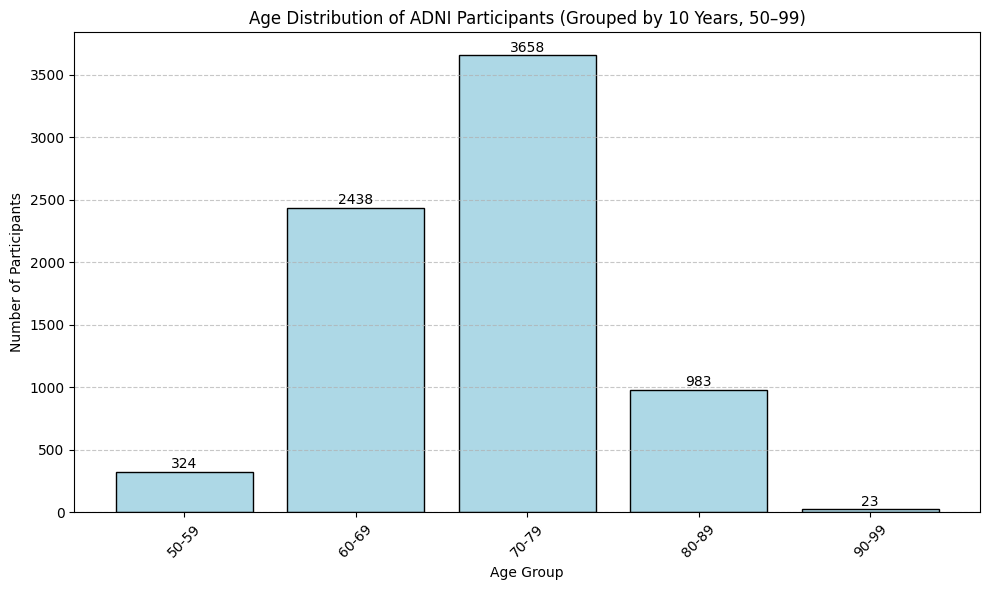

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Filter out missing or invalid ages
ADNI = ADNI .dropna(subset=['AGE'])
ADNI = ADNI [(ADNI ['AGE'] >= 20) & (ADNI ['AGE'] < 100)]

# Define bins from 50 to 100 by 10s
bins = list(range(50, 101, 10))  # [20, 30, 40, ..., 100]
labels = [f"{i}-{i+9}" for i in bins[:-1]]  # ['20-29', '30-39', ..., '90-99']

# Bin the ages
ADNI['Age Group'] = pd.cut(ADNI ['AGE'], bins=bins, labels=labels, right=False)

# Count per group
age_counts = ADNI ['Age Group'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(age_counts.index, age_counts.values, color='lightblue', edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 5, int(height), ha='center', va='bottom', fontsize=10) #Adjusting the text above the bars ,in our occasion the number of participants in each age group

plt.title("Age Distribution of ADNI Participants (Grouped by 10 Years, 50–99)")
plt.xlabel("Age Group")
plt.ylabel("Number of Participants")
plt.xticks(rotation=45) #Rotate the bars by 45 degrees
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE,BorderlineSMOTE
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from collections import Counter


X = ADNI[['MMSE', 'MOCA', 'PTEDUCAT','AGE','FAQ','LDELTOTAL','TRABSCOR','PTGENDER']]
ADNI['dementia_label'] = (ADNI['CDRSB'] >= 2.0).astype(int)
y = ADNI['dementia_label']


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


#Train - validate - test :70% - 15% - 15%
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

#borderline_smote_v2 = BorderlineSMOTE(kind='borderline-2', random_state=42)
smote = SMOTE(k_neighbors=7,random_state=42) # Use of SMOTE
#smote = SMOTE(k_neighbors=10, sampling_strategy=0.75)
#SMOTEENN()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print class distribution
print("Original dataset shape:", Counter(y))
print("Training set shape after resampling:", Counter(y_train_resampled))
print("Train size:", len(X_train_resampled))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Original dataset shape: Counter({0: 5209, 1: 2217})
Training set shape after resampling: Counter({1: 3646, 0: 3646})
Train size: 7292
Validation size: 1115
Test size: 1114


In [ ]:
from IPython.display import display

def print_classification_metrics_switched(report_dict, accuracy, roc_auc, class_labels,set_name="Set"):
    metrics = ["accuracy", "precision", "recall", "f1-score", "roc_auc"]

    # Build data dict with metrics as columns, classes as rows
    data = {metric.capitalize().replace("_", " "): [] for metric in metrics}

    for idx, cls in enumerate(class_labels):
        for metric in metrics:
            if metric == "accuracy":
                data["Accuracy"].append(accuracy * 100)
            elif metric == "roc_auc":
                data["Roc auc"].append(roc_auc * 100)
            else:
                data[metric.capitalize()].append(report_dict[str(idx)][metric] * 100)

    df = pd.DataFrame(data, index=class_labels)
    print(f"=== {set_name} Metrics ===")
    styled = df.style.format("{:.2f}%")
    display(styled)

In [ ]:
from pickle import TRUE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score ,classification_report,roc_curve, auc,precision_score, recall_score, f1_score,accuracy_score,roc_auc_score
from sklearn.model_selection import cross_validate

# Support Vector Machines (SVM)
#Train on resampled training set
svm_model = SVC(C=100, gamma='scale',kernel='rbf',probability=True)
svm_model.fit(X_train_resampled, y_train_resampled)

#Evaluation on Validation Set
y_val_pred = svm_model.predict(X_val)
y_val_prob = svm_model.predict_proba(X_val)[:, 1]


#Evaluation on Testing Set
y_test_pred = svm_model.predict(X_test)
y_test_prob = svm_model.predict_proba(X_test)[:, 1]



print_classification_metrics_switched(classification_report(y_val, y_val_pred, digits=2, output_dict=True), accuracy_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_prob),class_labels = ["Non-Demented (0)", "Demented (1)"],set_name="Validation")
print_classification_metrics_switched(classification_report(y_test, y_test_pred, digits=2, output_dict=True), accuracy_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_prob),class_labels = ["Non-Demented (0)", "Demented (1)"],set_name="Testing")

=== Validation Metrics ===


,Accuracy,Precision,Recall,F1-score,Roc auc
Non-Demented (0),88.07%,92.42%,90.41%,91.40%,93.20%
Demented (1),88.07%,78.57%,82.58%,80.53%,93.20%


=== Testing Metrics ===


,Accuracy,Precision,Recall,F1-score,Roc auc
Non-Demented (0),88.78%,93.04%,90.78%,91.90%,93.09%
Demented (1),88.78%,79.55%,84.08%,81.75%,93.09%


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score

def evaluate_with_cv(X, y, model,label,cv_splits):
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    metrics = {
        'Accuracy': cross_val_score(model, X, y, cv=skf, scoring='accuracy'),
        'Precision': cross_val_score(model, X, y, cv=skf, scoring='precision'),
        'Recall': cross_val_score(model, X, y, cv=skf, scoring='recall'),
        'F1-Score': cross_val_score(model, X, y, cv=skf, scoring='f1'),
        'ROC AUC': cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
    }

    # Convert to percentage and create DataFrame
    metrics_percent = {k: 100 * v for k, v in metrics.items()}
    df = pd.DataFrame(metrics_percent).T  # Transpose to have metrics as rows
    df.columns = [f'Fold {i+1}' for i in range(cv_splits)]
    df['Mean'] = df.mean(axis=1)

    # Round to 2 decimal places
    df = df.round(2)

    print(f"Cross-validation metrics (%)({label} set):")

    return df


In [ ]:
svm_model = SVC(C=100, gamma='scale',kernel='rbf',probability=True)
evaluate_with_cv(X_train_resampled, y_train_resampled, svm_model,"Training",cv_splits=10)

Cross-validation metrics (%)(Training set):


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Mean
Accuracy,88.22,87.67,86.83,89.30,89.30,89.85,89.44,89.03,88.61,89.85,88.81
Precision,89.74,88.73,88.32,91.35,91.84,92.42,90.88,90.80,91.94,89.19,90.52
Recall,86.30,86.30,84.93,86.85,86.30,86.85,87.64,86.81,84.62,90.66,86.73
F1-Score,87.99,87.50,86.59,89.04,88.98,89.55,89.23,88.76,88.13,89.92,88.57
ROC AUC,93.96,94.57,94.95,95.77,95.54,94.72,94.93,94.98,94.18,95.37,94.90


In [ ]:
from sklearn.svm import SVC
svm_model = SVC(C=100, gamma='scale',kernel='rbf',probability=True)
evaluate_with_cv(X_val, y_val, svm_model,"Validation",cv_splits=10)

Cross-validation metrics (%)(Validation set):


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Mean
Accuracy,91.07,92.86,89.29,90.18,83.93,88.29,87.39,85.59,82.88,88.29,87.98
Precision,100.00,100.00,92.31,96.00,80.77,91.67,85.19,77.42,71.88,88.46,88.37
Recall,69.70,75.76,70.59,70.59,61.76,66.67,69.70,72.73,69.70,69.70,69.69
F1-Score,82.14,86.21,80.00,81.36,70.00,77.19,76.67,75.00,70.77,77.97,77.73
ROC AUC,92.33,96.05,90.23,96.23,87.63,89.43,87.57,93.78,88.85,90.60,91.27


In [ ]:
from sklearn.svm import SVC
svm_model = SVC(C=100, gamma='scale',kernel='rbf',probability=True)
evaluate_with_cv(X_test, y_test, svm_model,"Testing",cv_splits=10)

Cross-validation metrics (%)(Testing set):


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Mean
Accuracy,89.29,86.61,88.39,86.61,84.68,90.99,87.39,87.39,88.29,84.68,87.43
Precision,92.00,82.76,92.00,85.19,80.77,89.66,75.68,80.65,83.33,78.57,84.06
Recall,69.70,70.59,67.65,67.65,63.64,78.79,84.85,75.76,75.76,66.67,72.10
F1-Score,79.31,76.19,77.97,75.41,71.19,83.87,80.00,78.12,79.37,72.13,77.36
ROC AUC,95.51,90.84,94.00,91.93,85.16,94.72,93.94,93.12,93.90,91.22,92.43


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report,roc_curve, auc,precision_score, recall_score, f1_score ,roc_auc_score
from sklearn.model_selection import cross_validate
from math import gamma



xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    colsample_bytree = 1.0,
    gamma = 0.13,
    learning_rate = 0.30,
    max_depth = 1,
    min_child_weight = 4,
    n_estimators = 350,
    subsample= 0.85
)
xgb_model.fit(X_train_resampled,y_train_resampled)


#Evaluation on Validation Set
y_val_pred = xgb_model.predict(X_val)
y_val_prob = xgb_model.predict_proba(X_val)[:, 1]

#Evaluation on Testing Set
y_test_pred = xgb_model.predict(X_test)
y_test_prob = xgb_model.predict_proba(X_test)[:, 1]

print_classification_metrics_switched(classification_report(y_val, y_val_pred, digits=2, output_dict=True), accuracy_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_prob),class_labels = ["Non-Demented (0)", "Demented (1)"],set_name="Validation")
print_classification_metrics_switched(classification_report(y_test, y_test_pred, digits=2, output_dict=True), accuracy_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_prob),class_labels = ["Non-Demented (0)", "Demented (1)"],set_name="Testing")

=== Validation Metrics ===


,Accuracy,Precision,Recall,F1-score,Roc auc
Non-Demented (0),88.43%,92.02%,91.43%,91.73%,93.97%
Demented (1),88.43%,80.18%,81.38%,80.77%,93.97%


=== Testing Metrics ===


,Accuracy,Precision,Recall,F1-score,Roc auc
Non-Demented (0),89.86%,92.39%,93.21%,92.80%,94.22%
Demented (1),89.86%,83.74%,81.98%,82.85%,94.22%


In [ ]:
xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    colsample_bytree = 1.0,
    gamma = 0.13,
    learning_rate = 0.30,
    max_depth = 1,
    min_child_weight = 4,
    n_estimators = 350,
    subsample= 0.85
)
evaluate_with_cv(X_train_resampled, y_train_resampled, xgb_model,"Training",cv_splits=10)

Cross-validation metrics (%)(Training set):


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Mean
Accuracy,90.96,89.73,88.61,91.77,90.67,91.36,92.18,91.63,91.08,91.36,90.94
Precision,91.88,90.96,89.83,93.20,94.07,92.18,92.05,92.44,91.88,90.79,91.93
Recall,89.86,88.22,87.12,90.14,86.85,90.41,92.31,90.66,90.11,92.03,89.77
F1-Score,90.86,89.57,88.46,91.64,90.31,91.29,92.18,91.54,90.98,91.41,90.82
ROC AUC,96.34,95.73,96.21,97.01,97.13,96.66,96.87,97.26,96.81,97.10,96.71


In [ ]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    colsample_bytree = 1.0,
    gamma = 0.13,
    learning_rate = 0.30,
    max_depth = 1,
    min_child_weight = 4,
    n_estimators = 350,
    subsample= 0.85
)
evaluate_with_cv(X_val,y_val, xgb_model,"Validation",cv_splits=10)

Cross-validation metrics (%)(Validation set):


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Mean
Accuracy,90.18,91.07,91.96,91.07,84.82,86.49,86.49,86.49,85.59,89.19,88.33
Precision,89.29,96.00,90.32,87.50,79.31,76.47,80.00,73.68,81.48,88.89,84.29
Recall,75.76,72.73,82.35,82.35,67.65,78.79,72.73,84.85,66.67,72.73,75.66
F1-Score,81.97,82.76,86.15,84.85,73.02,77.61,76.19,78.87,73.33,80.00,79.48
ROC AUC,95.40,97.97,92.61,95.51,88.57,95.26,92.00,93.51,88.23,96.08,93.51


In [ ]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    colsample_bytree = 1.0,
    gamma = 0.13,
    learning_rate = 0.30,
    max_depth = 1,
    min_child_weight = 4,
    n_estimators = 350,
    subsample= 0.85
)
evaluate_with_cv(X_test,y_test, xgb_model,"Testing",cv_splits=14)

Cross-validation metrics (%)(Testing set):


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Fold 11,Fold 12,Fold 13,Fold 14,Mean
Accuracy,93.75,88.75,88.75,87.50,88.75,90.00,86.25,85.00,93.67,92.41,88.61,91.14,84.81,89.87,89.23
Precision,91.30,85.71,94.12,85.00,82.61,86.36,84.21,77.27,84.62,86.96,81.82,94.74,75.00,86.36,85.43
Recall,87.50,75.00,66.67,70.83,79.17,79.17,66.67,70.83,95.65,86.96,78.26,75.00,75.00,79.17,77.56
F1-Score,89.36,80.00,78.05,77.27,80.85,82.61,74.42,73.91,89.80,86.96,80.00,83.72,75.00,82.61,81.04
ROC AUC,95.24,89.88,95.46,93.60,96.88,93.45,88.84,93.68,96.27,94.80,96.43,96.97,92.88,93.71,94.15


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, classification_report,roc_curve, auc,precision_score, recall_score, f1_score,accuracy_score,roc_auc_score
from sklearn.model_selection import cross_validate


rf_model = RandomForestClassifier(
    bootstrap=True,
    criterion='gini',
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=60,
    min_samples_split=3,
    n_estimators=900,
    random_state=42,
    class_weight=None
)
rf_model.fit(X_train_resampled, y_train_resampled)

#Evaluation on Validation Set
y_val_pred = rf_model.predict(X_val)
y_val_prob = rf_model.predict_proba(X_val)[:, 1]

#Evaluation on Testing Set
y_test_pred = rf_model.predict(X_test)
y_test_prob = rf_model.predict_proba(X_test)[:, 1]

print_classification_metrics_switched(classification_report(y_val, y_val_pred, digits=2, output_dict=True), accuracy_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_prob),class_labels = ["Non-Demented (0)", "Demented (1)"],set_name="Validation")
print_classification_metrics_switched(classification_report(y_test, y_test_pred,digits=2, output_dict=True), accuracy_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_prob),class_labels = ["Non-Demented (0)", "Demented (1)"],set_name="Testing")

=== Validation Metrics ===


,Accuracy,Precision,Recall,F1-score,Roc auc
Non-Demented (0),87.80%,92.61%,89.77%,91.17%,94.29%
Demented (1),87.80%,77.59%,83.18%,80.29%,94.29%


=== Testing Metrics ===


,Accuracy,Precision,Recall,F1-score,Roc auc
Non-Demented (0),88.69%,93.15%,90.52%,91.82%,94.01%
Demented (1),88.69%,79.15%,84.38%,81.69%,94.01%


In [ ]:
rf_model = RandomForestClassifier(
    bootstrap=True,
    criterion='gini',
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=60,
    min_samples_split=3,
    n_estimators=900,
    random_state=42,
    class_weight=None
)
evaluate_with_cv(X_train_resampled, y_train_resampled, rf_model,"Training",cv_splits=12)

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(
    bootstrap=True,
    criterion='gini',
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=60,
    min_samples_split=3,
    n_estimators=900,
    random_state=42,
    class_weight=None
)

evaluate_with_cv(X_val, y_val, rf_model,"Validation",cv_splits=12)

Cross-validation metrics (%)(Validation set):


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Fold 11,Fold 12,Mean
Accuracy,93.55,90.32,93.55,89.25,90.32,86.02,91.40,82.80,88.17,87.10,89.25,89.13,89.24
Precision,95.65,100.00,95.83,90.91,100.00,85.71,88.46,83.33,84.00,78.57,87.50,90.48,90.04
Recall,81.48,66.67,82.14,71.43,67.86,64.29,82.14,53.57,75.00,78.57,75.00,70.37,72.38
F1-Score,88.00,80.00,88.46,80.00,80.85,73.47,85.19,65.22,79.25,78.57,80.77,79.17,79.91
ROC AUC,97.59,95.23,95.88,94.62,94.23,94.01,96.21,92.58,91.21,94.45,91.21,91.51,94.06


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(
    bootstrap=True,
    criterion='gini',
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=60,
    min_samples_split=3,
    n_estimators=900,
    random_state=42,
    class_weight=None
)
evaluate_with_cv(X_test, y_test, rf_model,"Testing",cv_splits=12)

Cross-validation metrics (%)(Testing set):


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Fold 11,Fold 12,Mean
Accuracy,91.40,88.17,87.10,91.40,87.10,86.02,89.25,90.32,91.40,84.95,86.96,84.78,88.24
Precision,95.24,84.00,100.00,95.45,83.33,89.47,90.91,80.65,88.46,85.00,80.00,78.26,87.56
Recall,74.07,75.00,57.14,75.00,71.43,60.71,71.43,89.29,82.14,60.71,74.07,66.67,71.47
F1-Score,83.33,79.25,72.73,84.00,76.92,72.34,80.00,84.75,85.19,70.83,76.92,72.00,78.19
ROC AUC,96.02,90.55,92.86,97.47,95.55,87.91,93.35,93.79,96.70,92.69,95.56,89.17,93.47


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

lr_model = LogisticRegression(
     penalty='elasticnet',
      C=2,
      l1_ratio=0.9,
      max_iter=100,
      class_weight=None,
      solver='saga',
      random_state=42
)

lr_model.fit(X_train_resampled,y_train_resampled)

#Evaluation on Validation Set
y_val_pred = lr_model.predict(X_val)
y_val_prob = lr_model.predict_proba(X_val)[:, 1]

#Evaluation on Testing Set
y_test_pred = lr_model.predict(X_test)
y_test_prob = lr_model.predict_proba(X_test)[:, 1]

print_classification_metrics_switched(classification_report(y_val, y_val_pred, digits=2, output_dict=True), accuracy_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_prob),class_labels = ["Non-Demented (0)", "Demented (1)"],set_name="Validation")
print_classification_metrics_switched(classification_report(y_test, y_test_pred, digits=2, output_dict=True), accuracy_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_prob),class_labels = ["Non-Demented (0)", "Demented (1)"],set_name="Testing")

=== Validation Metrics ===


,Accuracy,Precision,Recall,F1-score,Roc auc
Non-Demented (0),88.88%,92.51%,91.56%,92.03%,94.06%
Demented (1),88.88%,80.65%,82.58%,81.60%,94.06%


=== Testing Metrics ===


,Accuracy,Precision,Recall,F1-score,Roc auc
Non-Demented (0),89.59%,92.68%,92.45%,92.56%,93.78%
Demented (1),89.59%,82.39%,82.88%,82.63%,93.78%


In [ ]:
evaluate_with_cv(X_train_resampled, y_train_resampled, lr_model,"Training",cv_splits=8)

Cross-validation metrics (%)(Training set):


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Mean
Accuracy,87.39,87.83,87.39,87.61,88.36,88.25,88.58,88.91,88.04
Precision,90.89,90.59,90.31,92.77,91.87,91.06,93.33,89.51,91.29
Recall,83.11,84.43,83.77,81.58,84.21,84.87,83.08,88.13,84.15
F1-Score,86.83,87.40,86.92,86.81,87.87,87.85,87.91,88.82,87.55
ROC AUC,95.08,94.47,94.54,94.83,94.84,94.89,96.08,95.54,95.03


In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
     penalty='elasticnet',
      C=2,
      l1_ratio=0.9,
      max_iter=100,
      class_weight=None,
      solver='saga',
      random_state=42
)

evaluate_with_cv(X_val, y_val, lr_model,"Validation",cv_splits=7)

Cross-validation metrics (%)(Validation set):


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Mean
Accuracy,91.25,90.62,89.31,90.57,88.05,84.91,88.68,89.05
Precision,94.74,92.31,94.12,88.10,86.84,77.27,85.71,88.44
Recall,75.00,75.00,68.09,78.72,70.21,70.83,75.00,73.26
F1-Score,83.72,82.76,79.01,83.15,77.65,73.91,80.00,80.03
ROC AUC,96.61,94.29,93.12,95.33,92.29,93.88,93.98,94.21


In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
     penalty='elasticnet',
      C=2,
      l1_ratio=0.9,
      max_iter=100,
      class_weight=None,
      solver='saga',
      random_state=42
)
evaluate_with_cv(X_test, y_test, lr_model,"Testing",cv_splits=15)

Cross-validation metrics (%)(Testing set):


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Fold 11,Fold 12,Fold 13,Fold 14,Fold 15,Mean
Accuracy,93.33,88.00,92.00,88.00,90.54,91.89,86.49,90.54,87.84,90.54,91.89,85.14,90.54,90.54,86.49,89.58
Precision,94.74,88.89,94.74,100.00,100.00,86.36,92.86,94.12,84.21,82.61,90.00,82.35,100.00,85.71,83.33,90.66
Recall,81.82,69.57,78.26,60.87,68.18,86.36,59.09,72.73,72.73,86.36,81.82,63.64,68.18,81.82,68.18,73.31
F1-Score,87.80,78.05,85.71,75.68,81.08,86.36,72.22,82.05,78.05,84.44,85.71,71.79,81.08,83.72,75.00,80.58
ROC AUC,96.91,91.22,96.40,91.64,99.21,95.89,90.47,92.74,95.10,93.71,93.44,94.49,92.57,95.19,89.77,93.92


In [ ]:
import lightgbm as lgb ,xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report,roc_curve, auc,precision_score, recall_score, f1_score,accuracy_score,roc_auc_score
from sklearn.model_selection import cross_validate
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
lgbm_model = LGBMClassifier(
    boosting_type='gbdt',
    reg_lambda=1,
    reg_alpha=0,
    path_smooth=0,
    num_leaves=255,
    n_estimators=1000,
    min_sum_hessian_in_leaf=0.1,
    min_child_samples=30,
    max_depth=11,
    learning_rate=0.3,
    feature_fraction=1.0,
    bagging_freq=3,
    bagging_fraction=0.7,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)


lgbm_model.fit(X_train_resampled, y_train_resampled)

# === Predict on validation set ===
y_val_pred = lgbm_model.predict(X_val)
y_val_probs = lgbm_model.predict_proba(X_val)[:, 1]

# === Predict on test set ===
y_test_pred = lgbm_model.predict(X_test)
y_test_probs = lgbm_model.predict_proba(X_test)[:, 1]

#print("------------------------------------------")
print_classification_metrics_switched(classification_report(y_val, y_val_pred, digits=2, output_dict=True), accuracy_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_probs),class_labels = ["Non-Demented (0)", "Demented (1)"],set_name="Validation")
print_classification_metrics_switched(classification_report(y_test, y_test_pred, digits=2, output_dict=True), accuracy_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_probs),class_labels = ["Non-Demented (0)", "Demented (1)"],set_name="Testing")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


=== Validation Metrics ===


,Accuracy,Precision,Recall,F1-score,Roc auc
Non-Demented (0),87.71%,89.86%,92.97%,91.39%,94.31%
Demented (1),87.71%,82.03%,75.38%,78.56%,94.31%


=== Testing Metrics ===


,Accuracy,Precision,Recall,F1-score,Roc auc
Non-Demented (0),89.05%,91.66%,92.83%,92.24%,93.97%
Demented (1),89.05%,82.66%,80.18%,81.40%,93.97%


In [ ]:
evaluate_with_cv(X_train_resampled, y_train_resampled, lgbm_model,"Training",cv_splits=6)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

Cross-validation metrics (%)(Training set):


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Mean
Accuracy,91.61,92.35,92.92,93.83,93.00,93.00,92.79
Precision,91.89,93.13,95.47,93.76,94.09,92.79,93.52
Recall,91.28,91.45,90.13,93.91,91.76,93.25,91.96
F1-Score,91.58,92.28,92.72,93.84,92.91,93.02,92.73
ROC AUC,97.02,97.48,97.86,97.65,97.74,97.70,97.58


In [ ]:
import lightgbm as lgb ,xgboost as xgb
from lightgbm import LGBMClassifier
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
lgbm_model = LGBMClassifier(
    boosting_type='gbdt',
    reg_lambda=1,
    reg_alpha=0,
    path_smooth=0,
    num_leaves=255,
    n_estimators=1000,
    min_sum_hessian_in_leaf=0.1,
    min_child_samples=30,
    max_depth=11,
    learning_rate=0.3,
    feature_fraction=1.0,
    bagging_freq=3,
    bagging_fraction=0.7,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
evaluate_with_cv(X_val, y_val, lgbm_model,"Validation",cv_splits=10)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

Cross-validation metrics (%)(Validation set):


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Mean
Accuracy,84.82,91.07,84.82,89.29,82.14,87.39,87.39,85.59,81.08,89.19,86.28
Precision,72.22,92.59,74.29,84.38,71.88,78.79,80.65,72.97,66.67,86.21,78.06
Recall,78.79,75.76,76.47,79.41,67.65,78.79,75.76,81.82,72.73,75.76,76.29
F1-Score,75.36,83.33,75.36,81.82,69.70,78.79,78.12,77.14,69.57,80.65,76.98
ROC AUC,90.87,97.39,93.74,94.83,88.01,94.60,92.93,93.16,85.39,94.21,92.51


In [ ]:
import lightgbm as lgb ,xgboost as xgb
from lightgbm import LGBMClassifier
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
lgbm_model = LGBMClassifier(
    boosting_type='gbdt',
    reg_lambda=1,
    reg_alpha=0,
    path_smooth=0,
    num_leaves=255,
    n_estimators=1000,
    min_sum_hessian_in_leaf=0.1,
    min_child_samples=30,
    max_depth=11,
    learning_rate=0.3,
    feature_fraction=1.0,
    bagging_freq=3,
    bagging_fraction=0.7,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
evaluate_with_cv(X_test, y_test, lgbm_model,"Testing",cv_splits=10)

Cross-validation metrics (%)(Testing set):


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Mean
Accuracy,92.86,89.29,90.18,91.96,82.88,90.09,91.89,87.39,90.99,86.49,89.40
Precision,90.32,89.29,89.66,90.32,75.00,84.38,85.29,82.76,84.85,78.12,85.00
Recall,84.85,73.53,76.47,82.35,63.64,81.82,87.88,72.73,84.85,75.76,78.39
F1-Score,87.50,80.65,82.54,86.15,68.85,83.08,86.57,77.42,84.85,76.92,81.45
ROC AUC,94.55,93.67,94.80,95.55,85.00,93.82,94.52,95.42,94.44,92.85,93.46


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report,roc_curve, auc,precision_score, recall_score, f1_score,accuracy_score,roc_auc_score
from sklearn.model_selection import cross_validate
import warnings

warnings.filterwarnings("ignore", category=UserWarning)#To avoid any warning messages


# === Build the ANN Model ===
model = Sequential([

    Dense(1024, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    BatchNormalization(),
    #Dropout(0.5),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(16, activation='relu'),
    Dropout(0.2),

    Dense(8, activation='relu'),

    Dense(1, activation='sigmoid')  # Binary output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Early Stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# === Train the Model ===
history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# === Evaluate on Validation Set ===
val_preds = (model.predict(X_val) > 0.5).astype(int)
#print("\nValidation Classification Report:")
#print(classification_report(y_val, val_preds))
print_classification_metrics_switched(classification_report(y_val, val_preds, digits=2, output_dict=True), accuracy_score(y_val, val_preds), roc_auc_score(y_val, model.predict(X_val)),class_labels = ["Non-Demented (0)", "Demented (1)"],set_name="Validation")
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("Validation ROC AUC:", roc_auc_score(y_val, model.predict(X_val)))

# === Evaluate on Test Set ===
test_preds = (model.predict(X_test) > 0.5).astype(int)
#print("\nTest Classification Report:")
#print(classification_report(y_test, test_preds))
print_classification_metrics_switched(classification_report(y_test, test_preds, digits=2, output_dict=True), accuracy_score(y_test, test_preds),roc_auc_score(y_test, model.predict(X_test)),class_labels = ["Non-Demented (0)", "Demented (1)"],set_name="Testing")
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("Test ROC AUC:", roc_auc_score(y_test, model.predict(X_test)))

AttributeError: partially initialized module 'jax' has no attribute 'version' (most likely due to a circular import)

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_ann_model(input_dim, learning_rate=0.0005):
    """
    Builds and compiles a deep ANN model for binary classification.

    Parameters:
        input_dim (int): Number of input features.
        learning_rate (float): Learning rate for the Adam optimizer.

    Returns:
        model (tf.keras.Model): Compiled ANN model.
    """
    # The activation function used in all hidden layers is 'ReLU'.
    # Each hidden layer is followed by batch normalization for improved stability,
    # and dropout is applied to retain only the most important information.
    model = Sequential([
        Input(shape=(input_dim,)),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(16, activation='relu'),
        Dropout(0.2),

        Dense(8, activation='relu'),

        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    model.fit(X_train_resampled, y_train_resampled, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)

    return model

In [ ]:
def evaluate_ann_model(X_train, y_train, X_val, y_val, X_test, y_test,
                      model_builder, input_dim, label="ANN",
                      cv_splits=5, epochs=50, batch_size=32):
    """
    Evaluate ANN model with cross-validation on training data,
    and separate evaluations on validation and test sets

    Parameters:
        X_train, y_train: Training data (will be CV split)
        X_val, y_val: Validation data
        X_test, y_test: Test data
        model_builder: Function that returns compiled Keras model
        input_dim: Number of input features
        label: Model label for printing
        cv_splits: Number of cross-validation folds
        epochs: Training epochs
        batch_size: Batch size

    Returns:
        Tuple of (cv_results, val_metrics, test_metrics) DataFrames
    """
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    cv_metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1-Score': [],
        'ROC AUC': []
    }

    val_set_metrics = []
    test_set_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"\n--- Fold {fold+1} ---")
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Apply SMOTE only on the training fold
        resampler = SMOTE(random_state=42, k_neighbors=7)
        X_train_res, y_train_res = resampler.fit_resample(X_train_fold, y_train_fold)

        # Build and train model
        model = model_builder(input_dim=input_dim)
        model.fit(X_train_res, y_train_res,
                  epochs=epochs,
                  batch_size=batch_size,
                  verbose=0)

        # Predict on validation fold
        y_pred = (model.predict(X_val_fold) > 0.5).astype(int)
        y_proba = model.predict(X_val_fold)

        # Metrics on validation fold
        cv_metrics['Accuracy'].append(accuracy_score(y_val_fold, y_pred))
        cv_metrics['Precision'].append(precision_score(y_val_fold, y_pred))
        cv_metrics['Recall'].append(recall_score(y_val_fold, y_pred))
        cv_metrics['F1-Score'].append(f1_score(y_val_fold, y_pred))
        cv_metrics['ROC AUC'].append(roc_auc_score(y_val_fold, y_proba))

        # Evaluate on external validation set
        val_pred = (model.predict(X_val) > 0.5).astype(int)
        val_proba = model.predict(X_val)
        val_metrics = {
            'Accuracy': 100 * accuracy_score(y_val, val_pred),
            'Precision': 100 * precision_score(y_val, val_pred),
            'Recall': 100 * recall_score(y_val, val_pred),
            'F1-Score': 100 * f1_score(y_val, val_pred),
            'ROC AUC': 100 * roc_auc_score(y_val, val_proba)
        }
        val_set_metrics.append(val_metrics)
        print("Validation set performance:", {k: round(v, 2) for k, v in val_metrics.items()})

        # Evaluate on test set
        test_pred = (model.predict(X_test) > 0.5).astype(int)
        test_proba = model.predict(X_test)
        test_metrics = {
            'Accuracy': 100 * accuracy_score(y_test, test_pred),
            'Precision': 100 * precision_score(y_test, test_pred),
            'Recall': 100 * recall_score(y_test, test_pred),
            'F1-Score': 100 * f1_score(y_test, test_pred),
            'ROC AUC': 100 * roc_auc_score(y_test, test_proba)
        }
        test_set_metrics.append(test_metrics)
        print("Test set performance:", {k: round(v, 2) for k, v in test_metrics.items()})

    # Create CV results DataFrame
    cv_metrics_percent = {k: 100 * np.array(v) for k, v in cv_metrics.items()}
    cv_results = pd.DataFrame(cv_metrics_percent).T
    cv_results.columns = [f'Fold {i+1}' for i in range(cv_splits)]
    cv_results['Mean'] = cv_results.mean(axis=1).round(2)
    cv_results = cv_results.round(2)

    # Create DataFrames for val/test per fold
    val_fold_df = pd.DataFrame(val_set_metrics).T
    val_fold_df.columns = [f'Fold {i+1}' for i in range(cv_splits)]
    val_fold_df['Mean'] = val_fold_df.mean(axis=1).round(2)

    test_fold_df = pd.DataFrame(test_set_metrics).T
    test_fold_df.columns = [f'Fold {i+1}' for i in range(cv_splits)]
    test_fold_df['Mean'] = test_fold_df.mean(axis=1).round(2)

    # Final training on full training set
    resampler = SMOTE(random_state=42, k_neighbors=7)
    X_train_res, y_train_res = resampler.fit_resample(X_train, y_train)

    final_model = model_builder(input_dim=input_dim)
    final_model.fit(X_train_res, y_train_res,
                   epochs=epochs,
                   batch_size=batch_size,
                   verbose=0)

    # Final validation set evaluation
    val_pred = (final_model.predict(X_val) > 0.5).astype(int)
    val_proba = final_model.predict(X_val)

    val_metrics = {
        'Accuracy': 100 * accuracy_score(y_val, val_pred),
        'Precision': 100 * precision_score(y_val, val_pred),
        'Recall': 100 * recall_score(y_val, val_pred),
        'F1-Score': 100 * f1_score(y_val, val_pred),
        'ROC AUC': 100 * roc_auc_score(y_val, val_proba)
    }
    val_results = pd.DataFrame.from_dict(val_metrics, orient='index', columns=['Value']).round(2)

    # Final test set evaluation
    test_pred = (final_model.predict(X_test) > 0.5).astype(int)
    test_proba = final_model.predict(X_test)

    test_metrics = {
        'Accuracy': 100 * accuracy_score(y_test, test_pred),
        'Precision': 100 * precision_score(y_test, test_pred),
        'Recall': 100 * recall_score(y_test, test_pred),
        'F1-Score': 100 * f1_score(y_test, test_pred),
        'ROC AUC': 100 * roc_auc_score(y_test, test_proba)
    }
    test_results = pd.DataFrame.from_dict(test_metrics, orient='index', columns=['Value']).round(2)

    # Print summaries
    print(f"\nCross-validation results ({label}):")
    print(cv_results)

    print(f"\nValidation set results after each fold ({label}):")
    print(val_fold_df)

    print(f"\nTest set results after each fold ({label}):")
    print(test_fold_df)

    print(f"\nFinal Validation set results ({label}):")
    print(val_results)

    print(f"\nFinal Test set results ({label}):")
    print(test_results)

    return cv_results, val_results, test_results



In [ ]:
cv_results, val_results, test_results = evaluate_ann_model(
    X_train=X_train_resampled,
    y_train=y_train_resampled,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    model_builder=build_ann_model,
    input_dim=X_train_resampled.shape[1],
    label="ANN with simple SMOTE",
    cv_splits=4,
    epochs=100,
    batch_size=64
)


--- Fold 1 ---
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Validation set performance: {'Accuracy': 88.43, 'Precision': 78.33, 'Recall': 84.68, 'F1-Score': 81.39, 'ROC AUC': np.float64(93.96)}
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test set performance: {'Accuracy': 88.87, 'Precision': 79.27, 'Recall': 84.98, 'F1-Score': 82.03, 'ROC AUC': np.float64(93.72)}

--- Fold 2 ---
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Validation set performance: {'Accuracy': 87.53, 'Precision': 78.87, 'Recall': 79.58, 'F1-Score': 79.22, 'ROC AUC': np.float64(93.87)}
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test set performance: {'Accuracy': 89.14, 'Precision': 81.55, 'Recall': 82.28, 'F1-Score': 81.91, 'ROC 

<Figure size 1200x700 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

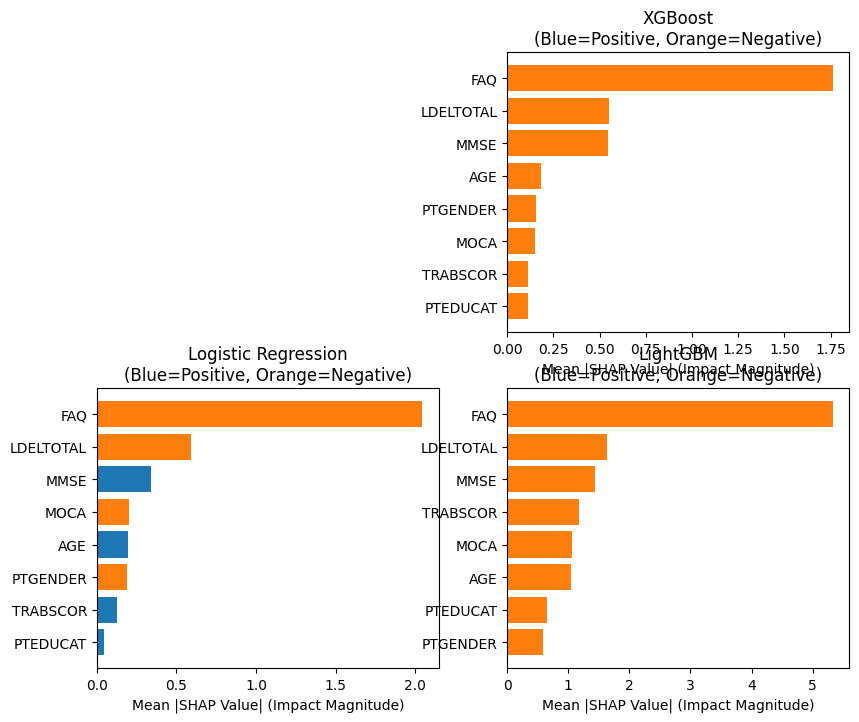

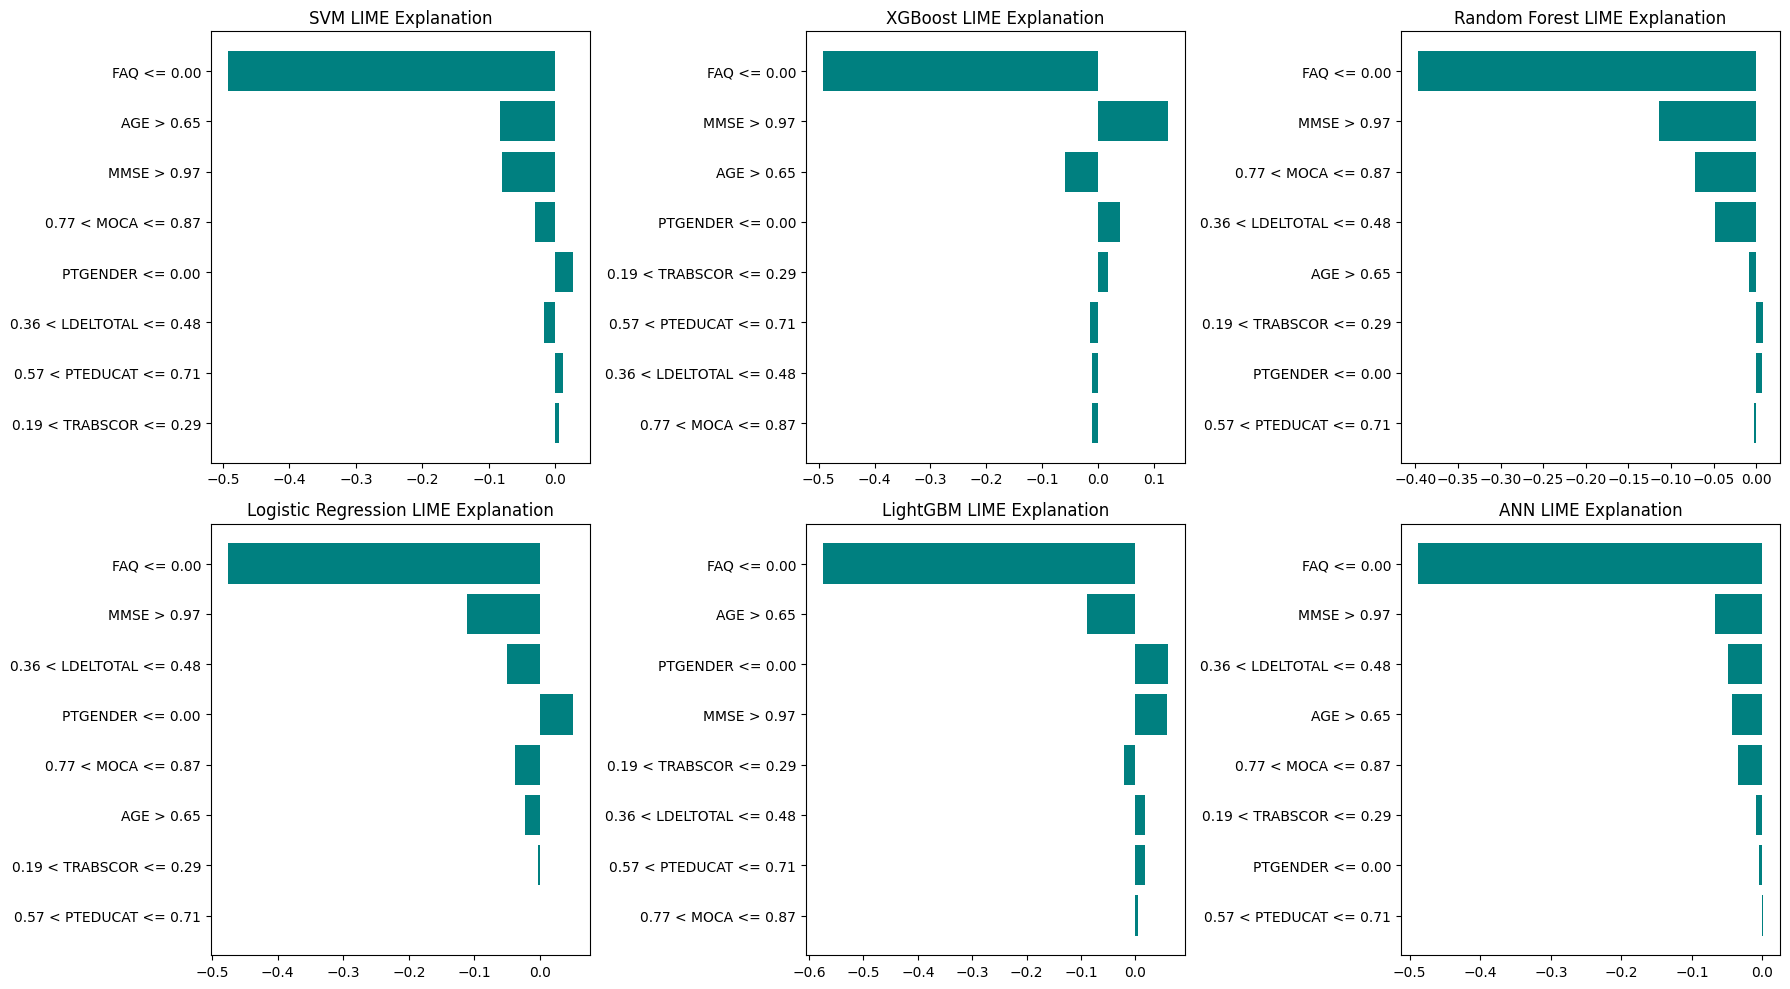

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
import pandas as pd

# Define feature names
feature_names = ['MMSE', 'MOCA', 'PTEDUCAT', 'AGE', 'FAQ', 'LDELTOTAL', 'TRABSCOR', 'PTGENDER']
class_names = ['No Dementia', 'Dementia']

# Convert validation set to DataFrames
X_val_df = pd.DataFrame(X_val, columns=feature_names)
y_val_df = pd.Series(y_val)

# Selecting a random sample from the validation set to explain
X_sample = X_val_df.sample(n=1, random_state=42).iloc[0] # Random sample of features
y_sample = y_val_df.iloc[0] # Corresponding label for the sample

# Use resampled training data
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=feature_names)
X_train_resampled_np = X_train_resampled_df.values

#Building again the ANN model
input_dim = X_train_resampled.shape[1]
ann_model = build_ann_model(input_dim=input_dim)

# Initialize LIME explainer with resampled training data
explainer = LimeTabularExplainer(
    training_data=X_train_resampled_np,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification', # Classification task
    discretize_continuous=True,# Discretize continuous features
    verbose=False
)

# Ensure your models support predict_proba
models = {
    "SVM": svm_model,
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Logistic Regression": lr_model,
    "LightGBM": lgbm_model,
    "ANN": lambda x: np.hstack([
        1 - ann_model.predict(x, verbose=0),
        ann_model.predict(x, verbose=0)
    ])
}

# Plot explanations
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, (name, model) in enumerate(models.items()):
    # If model is a function (like the ANN lambda), use it as is
    predict_fn = model if callable(model) else model.predict_proba

    # Explain instance
    exp = explainer.explain_instance(
        data_row=X_sample.values,
        predict_fn=predict_fn,
        num_features=10
    )

    # Create horizontal bar plot from explanation
    weights = dict(exp.as_list())
    sorted_weights = dict(sorted(weights.items(), key=lambda item: abs(item[1]), reverse=True))
    #Features with positive weight push toward to "Dementia" , otherwise (negative weight features) push toward to "No dementia"
    axs[i].barh(list(sorted_weights.keys()), list(sorted_weights.values()), color='teal')
    axs[i].set_title(f"{name} LIME Explanation")
    axs[i].invert_yaxis()

plt.tight_layout()
plt.show()


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


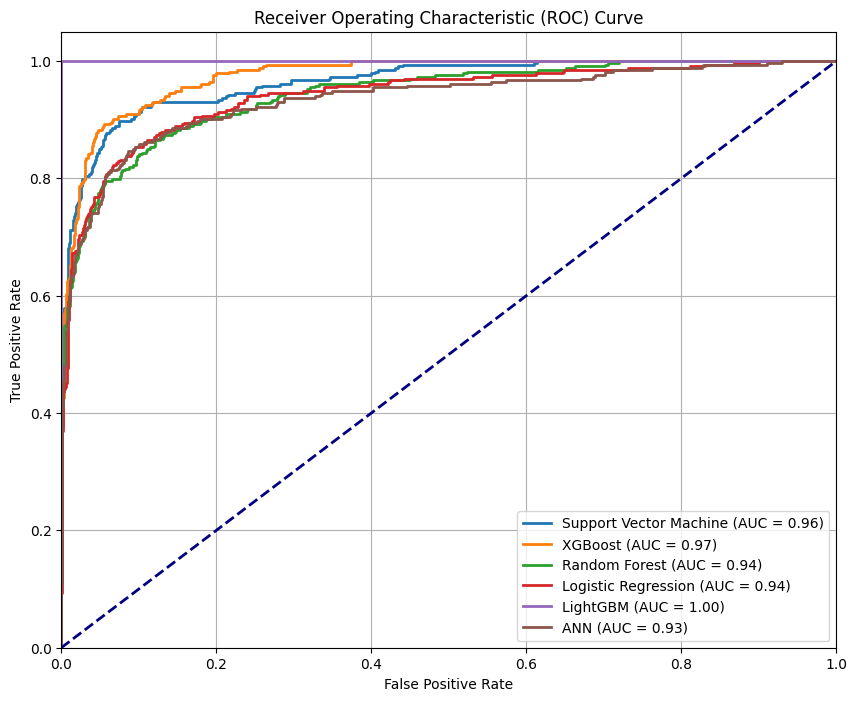

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

input_dim = X_train_resampled.shape[1]
ann_model = build_ann_model(input_dim=input_dim)

models = {
    'Support Vector Machine': svm_model,
     'XGBoost': xgb_model,
    'Random Forest': rf_model,
    'Logistic Regression': lr_model,
    'LightGBM': lgbm_model,
    'ANN': ann_model
}


plt.figure(figsize=(10, 8))
performance_metrics = {}


for model_name, model in models.items():

    if model_name == 'ANN':
        y_probs = model.predict(X_test)
    else:
        model.fit(X_train_resampled,y_train_resampled)
        y_probs = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    performance_metrics[model_name] = {'fpr': fpr,'tpr': tpr,'roc_auc': roc_auc}
    plt.plot(fpr, tpr, lw=2,label=f'{model_name} (AUC = {roc_auc:.2f})') #(AUC = {roc_auc:.2f})

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8693 - loss: 0.3172
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


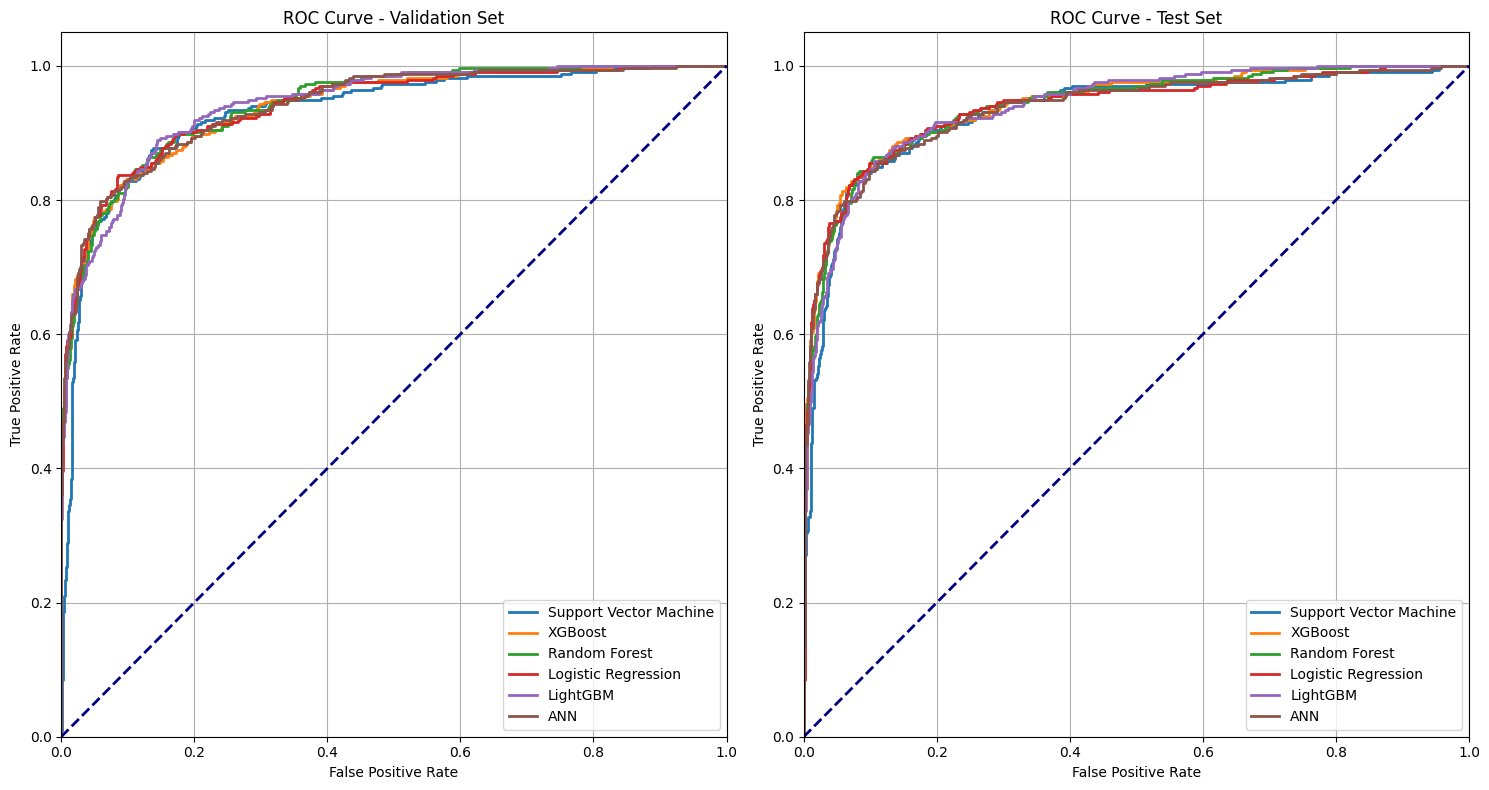

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

input_dim = X_train_resampled.shape[1]
ann_model = build_ann_model(input_dim=input_dim)

models = {
    'Support Vector Machine': svm_model,
    'XGBoost': xgb_model,
    'Random Forest': rf_model,
    'Logistic Regression': lr_model,
    'LightGBM': lgbm_model,
    'ANN': ann_model
}

# Create subplots: 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Performance metrics dictionary
performance_metrics = {}

for model_name, model in models.items():
    # Train on the training set
    model.fit(X_train_resampled, y_train_resampled)

    # Predict probabilities on the validation set
    if model_name == 'ANN':
        y_probs_val = model.predict(X_val)[:, 0]  # Assuming ANN model returns probabilities
    else:
        y_probs_val = model.predict_proba(X_val)[:, 1]

    fpr_val, tpr_val, _ = roc_curve(y_val, y_probs_val)
    roc_auc_val = auc(fpr_val, tpr_val)
    performance_metrics[f'{model_name} (Val)'] = {'fpr': fpr_val, 'tpr': tpr_val, 'roc_auc': roc_auc_val}

    # Plot ROC curve for the validation set in the first subplot
    ax1.plot(fpr_val, tpr_val, lw=2, label=f'{model_name}') #(AUC = {roc_auc_val:.2f})

    # Predict probabilities on the test set
    if model_name == 'ANN':
        y_probs_test = model.predict(X_test)[:, 0]  # Assuming ANN model returns probabilities
    else:
        y_probs_test = model.predict_proba(X_test)[:, 1]

    fpr_test, tpr_test, _ = roc_curve(y_test, y_probs_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    performance_metrics[f'{model_name} (Test)'] = {'fpr': fpr_test, 'tpr': tpr_test, 'roc_auc': roc_auc_test}

    # Plot ROC curve for the test set in the second subplot
    ax2.plot(fpr_test, tpr_test, lw=2, label=f'{model_name}') #(AUC = {roc_auc_test:.2f})

# Plot random classifier line for both subplots
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set the limits and labels for the first subplot (validation)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve - Validation Set')
ax1.legend(loc="lower right")
ax1.grid(True)

# Set the limits and labels for the second subplot (test)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve - Test Set')
ax2.legend(loc="lower right")
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

